# Lezione 7

In [ ]:
from liblet import Grammar, Production, Derivation, ProductionGraph, closure, prods2table, cyk2table

from L06 import cyk, remove_unproductive_unreachable # codice dalla precedente leizone, vedi il file L06.py

## Eliminazione ε-regole (Sez. 4.2.3.1)

Due passi, ottenuti tramite *chiusura*, consentono di rimpiazzare un simbolo nei lati destri con `replace_in_rhs` e quindi applicare il primo passo a tutti i simboli che compaiono in una ε-regola con `inline_ε_rules`.

In [ ]:
@closure
def replace_in_rhs(G, A):
    Ap = A + '’'
    prods = set()
    for B, β in G.P:
        if A in β:
            pos = β.index(A)
            rhs = β[:pos] + β[pos + 1:]
            if len(rhs) == 0: rhs = ('ε', )
            prods.add(Production(B, rhs))
            prods.add(Production(B, β[:pos] + (Ap, ) + β[pos + 1:]))
        else:
            prods.add(Production(B, β))    
    return Grammar(G.N | {Ap}, G.T, prods, G.S)

In [ ]:
# esempio d'uso

U = Grammar.from_string("""
S -> x A y A z
A -> a
""")

prods2table(replace_in_rhs(U, 'A'))

In [ ]:
@closure
def inline_ε_rules(G_seen):
    G, seen = G_seen
    for A in G.N - seen:
        if ('ε', ) in G.alternatives(A):
            return replace_in_rhs(G, A), seen | {A}
    return G, seen

In [ ]:
# esempio d'uso

U = Grammar.from_string("""
S -> A
A -> B C
B -> ε
C -> ε
""")

prods2table(inline_ε_rules((U, set()))[0])

Usando i due passi precedenti è semplice scrivere il passo di eliminazione

In [ ]:
def eliminate_ε_rules(G):
    Gp, _ = inline_ε_rules((G, set()))
    prods = set(Gp.P)
    for Ap in Gp.N - G.N:
        A = Ap[:-1]
        for α in set(Gp.alternatives(A)) - {('ε', )}:
            prods.add(Production(Ap, α))
    return Grammar(Gp.N, Gp.T, prods, Gp.S)

In [ ]:
# esempio d'uso (fig. 4.10, pag. 120)

U = Grammar.from_string("""
S -> L a M
L -> L M 
L -> ε
M -> M M
M -> ε
""")

prods2table(eliminate_ε_rules(U))

## Eliminazione regole unitarie (Sez. 4.2.3.2)

In [ ]:
def eliminate_unit_rules(G):
    @closure
    def _eliminate_unit_rules(G_seen):
        G, seen = G_seen
        for P in set(filter(Production.such_that(rhs_len = 1), G.P)) - seen:
            A, (B, ) = P
            if B in G.N:            
                prods = (set(G.P) | {Production(A, α) for α in G.alternatives(B)}) - {P}
                return Grammar(G.N, G.T, prods, G.S), seen | {P}
        return G, seen
    return _eliminate_unit_rules((G, set()))[0]

In [ ]:
# esempio d'uso

U = Grammar.from_string("""
S -> A
A -> B
B -> A | b
""")

prods2table(eliminate_unit_rules(U))

### Un esempio più elaborato

In [ ]:
# fig. 4.6, pag. 112

G = Grammar.from_string("""
Number -> Integer | Real
Integer -> Digit | Integer Digit
Real -> Integer Fraction Scale
Fraction -> . Integer
Scale -> e Sign Integer | Empty
Digit -> 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9
Sign -> + | -
Empty -> ε
""")

In [ ]:
# fig. 4.12, pag. 120 (a meno di Empty’)

prods2table(eliminate_ε_rules(G))

Data la `G` per i numeri con la virgola, si ottiene `Gp` coi primi due passi di cui sopra.

In [ ]:
# fig. 4.13, pag. 121

Gp = eliminate_unit_rules(eliminate_ε_rules(G))
prods2table(Gp)

## Eliminare regole/simboli non produttive e  non raggiungibili (Sez. 2.9.5.1-2)

In [ ]:
# fig. 4.14, pag. 122

Gp_clean = remove_unproductive_unreachable(Gp)
prods2table(Gp_clean)

## Riduzione in forma normale (Sez. 4.3.2.4)

### Caso $A\to \alpha a \beta$

In [ ]:
def transform_nonsolitary(G):
    prods = set()
    for A, α in G.P:
        if len(α) > 1 and set(α) & G.T:
            rhs = []
            for x in α:
                if x in G.T:
                    N = 'N{}'.format(x)
                    prods.add(Production(N, (x, )))
                    rhs.append(N)
                else:
                    rhs.append(x)
            prods.add(Production(A, rhs))
        else:            
            prods.add(Production(A, α))
    return Grammar(G.N | {A for A, α in prods}, G.T, prods, G.S)

In [ ]:
# esempio d'uso

U = Grammar.from_string("""
S -> x S y S x
""")

prods2table(transform_nonsolitary(U))

### Caso $A\to X_1 X_2\ldots X_n$

In [ ]:
def make_binary(G):
    prods = set()
    for A, α in G.P:
        if len(α) > 2:
            Ai = '{}{}'.format(A, 1)
            prods.add(Production(Ai, α[:2]))
            for i, Xi in enumerate(α[2:-1], 2):
                prods.add(Production('{}{}'.format(A, i), (Ai, Xi)))
                Ai = '{}{}'.format(A, i)
            prods.add(Production(A, (Ai, α[-1])))
        else:
            prods.add(Production(A, α))
    return Grammar(G.N | {A for A, α in prods}, G.T, prods, G.S)

In [ ]:
# esempio d'uso

U = Grammar.from_string("""
S -> A B C D
""")

prods2table(make_binary(U))

### Di nuovo, l'esempio più elaborato

In [ ]:
# fig. 4.15, pag. 123 (rinominando alcuni non terminali)

G_cnf = make_binary(transform_nonsolitary(Gp_clean))
prods2table(G_cnf)

# Parsing CYK con  G in forma CNF

In [ ]:
# fig. 4.16, pag. 123

INPUT = '32.5e+1'
R = cyk(G_cnf, INPUT)
cyk2table(R)

## Una derivazione leftmost

Per ottenere una derivazione *leftmost* ragioniamo come per la funzione `parse_lol` della precedente lezione, ma invece di restituire un *lol* restituiamo l'indice della produzione in gioco (ottenuto invocando `G.P.index`)

In [ ]:
def get_leftmost_prods(G, R, INPUT):
    def prods(X, i, l):
        if l == 1:
            return [G.P.index(Production(X, (INPUT[i - 1],)))]
        for A, (B, C) in filter(Production.such_that(lhs = X, rhs_len = 2), G.P):
            for k in range(1, l):
                if B in R[(i, k)] and C in R[(i + k, l - k)]:
                    return [G.P.index(Production(A, (B, C)))] + prods(B, i, k) + prods(C, i + k, l - k)
    return prods(G.S, 1, len(INPUT))            

In [ ]:
leftmost_prods = get_leftmost_prods(G_cnf, R, INPUT)
leftmost_prods

[11, 23, 5, 36, 29, 1, 8, 4, 26, 3, 21, 0, 39]

In [ ]:
d = Derivation(G_cnf).leftmost(leftmost_prods)
d

Number -> Number1 Scale’ -> Integer Fraction Scale’ -> Integer Digit Fraction Scale’ -> 3 Digit Fraction Scale’ -> 3 2 Fraction Scale’ -> 3 2 N. Integer Scale’ -> 3 2 . Integer Scale’ -> 3 2 . 5 Scale’ -> 3 2 . 5 Scale’1 Integer -> 3 2 . 5 Ne Sign Integer -> 3 2 . 5 e Sign Integer -> 3 2 . 5 e + Integer -> 3 2 . 5 e + 1

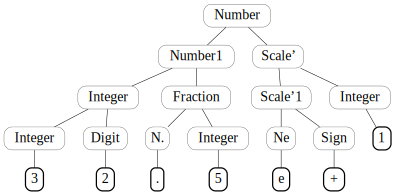

In [ ]:
ProductionGraph(d)    

Come si possono ottenere le produzioni di una derivazione *rightomst*?

## Il parsing in G (non in CNF)? (Sez. 4.2.6)

Un primo requisito, per poter effettuare il parsing secondo le produzioni della grammatica originale è non eliminare i simboli improduttivi e irraggiungibili.

In [ ]:
# Non effettuiamo la pulizia

Gp_cnf = transform_nonsolitary(make_binary(Gp))
prods2table(Gp_cnf)

Ora calcoliamo la tabella `Rp` e la completiamo con le ε-regole

In [ ]:
# Otteniamo Rp tramite il parsing rispetto alla grammatica non ripulita Gp_cnf

INPUT = '32.5e+1'
Rp = cyk(Gp_cnf, INPUT)

In [ ]:
# Calcoliamo l'insieme dei simboli A tali che A -> ε

Rε = {A for A in Gp_cnf.N if ('ε', ) in Gp_cnf.alternatives(A)}

In [ ]:
# Li aggiungiamo in fondo alla tabella

for i in range(len(INPUT) + 2): Rp[(i, 0)] = Rε

Ora costruiamo (per una assegnata tabella `R`  e un assegnato `INPUT` la funzione `derives(ω, i, l)` che restituisce una lista se la forma sentenziale corispondete al primo argomento deriva (in base alle informaizoni nella tabella) la sottoparola dell'input lunga `l` che inizia dall'`i`-esimo simbolo, oppure `None`; la lista è un elenco di lungezze, ciascuna delle quali corrisponde a quanti simboli della sottoparola derivano da ciascun non terminale della forma sentenziale.

In [ ]:
def make_derives(R, INPUT):
    def derives(ω, i, l):
        if not ω or ('ε', ) == ω: 
            return [] if l == 0 else None
        X, *χ = ω
        if X in G.T:
            if i <= len(INPUT) and X == INPUT[i - 1]:
                s = derives(χ, i + 1, l - 1)
                if s is not None: return [1] + s
        else:
            for k in range(0, l + 1):
                if (i, k) in R and X in R[(i, k)]:
                    s = derives(χ, i + k, l - k)
                    if s is not None: return [k] + s
        return None
    return derives

In [ ]:
# costruiamo derive sulla tabella ed input precedenti

derives = make_derives(Rp, INPUT)

In [ ]:
# una prova di esecuzione 

derives(['Integer', 'Fraction', 'Scale'], 1, len(INPUT))

[2, 2, 3]

I tre non terminali (che sono il lato destro della produzione `Real -> Integer Fraction Scale`) producono l'input (ossia tutti e 7 i suoi simboli a partire dal primo) e più precisamente:

- `Integer` produrrà '35' (una sottoparola lunga 2),
- `Fraction` produrrà '.5' (una sottoparola lunga 2),
- `Scale` produrrà 'e+1', (una sottoparola lunga 3).

Una volta scritta la suddetta funzione basta seguire l'algoritmo descritto a partire da pag. 115.

In [ ]:
def get_original_leftmost_prods(G, derives, N):
    def prods(X, i, l):
        if X in G.T: return []
        for A, α in filter(Production.such_that(lhs = X), G.P):
            d = derives(α, i, l)
            if d is None: continue
            res = [G.P.index(Production(A, α))]
            for B, l in zip(α, d): 
                res.extend(prods(B, i, l))
                i += l
            return res
    return prods(G.S, 1, N)

Ora possiamo costruire (le produzioni, la derivazione e) l'albero nella grammatica originale!

In [ ]:
# le produzioni

leftmost_prods = get_original_leftmost_prods(G, derives, len(INPUT))
leftmost_prods

[1, 4, 3, 2, 11, 10, 5, 2, 13, 6, 18, 2, 9]

In [ ]:
# la derivazione

d = Derivation(G).leftmost(leftmost_prods)
d

Number -> Real -> Integer Fraction Scale -> Integer Digit Fraction Scale -> Digit Digit Fraction Scale -> 3 Digit Fraction Scale -> 3 2 Fraction Scale -> 3 2 . Integer Scale -> 3 2 . Digit Scale -> 3 2 . 5 Scale -> 3 2 . 5 e Sign Integer -> 3 2 . 5 e + Integer -> 3 2 . 5 e + Digit -> 3 2 . 5 e + 1

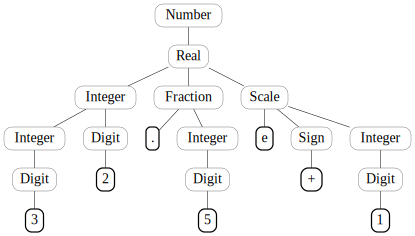

In [ ]:
# l'albero

ProductionGraph(d)

### E le ε-produzioni?

In [ ]:
INPUT = tuple('32.5')

In [ ]:
Rp = cyk(Gp_cnf, INPUT)
Rε = {A for A in Gp_cnf.N if ('ε', ) in Gp_cnf.alternatives(A)}
for i in range(len(INPUT) + 2): Rp[(i, 0)] = Rε

In [ ]:
leftmost_prods = get_original_leftmost_prods(G, make_derives(Rp, INPUT), len(INPUT))

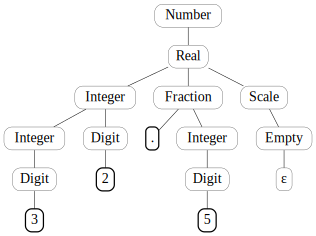

In [ ]:
ProductionGraph(Derivation(G).leftmost(leftmost_prods))    